<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/6_Implementations_of_LMs_activations_gradients_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- This colab helps to understand more about activations, gradients, and batch norm.

- It will help to understand why **RNN is harder to optimize** compared to CNN etc.

# Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [62]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

--2023-09-10 15:56:33--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-09-10 15:56:33 (7.51 MB/s) - ‘names.txt.1’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [63]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [64]:
len(words)

32033

# Build vocabularoy

In [65]:
chars = sorted(list(set(''.join(words))))

stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0

itos = {i: c for c, i in stoi.items()}

vocab_size = len(stoi)

assert vocab_size == 27

# Create DS

In [66]:
block_size = 3  # Context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X = []
  Y = []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(f"{''.join(itos[c] for c in context)}--->{itos[ix]}")
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  return X, Y

In [67]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(f'train: {len(Xtr)}, dev: {len(Xdev)}, test: {len(Xte)}')

train: 182625, dev: 22655, test: 22866


# MLP Revisited

## Model params

In [120]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size,), generator=g)

parameters = [C, W1, b1, W2, b2]
n_params = sum(p.nelement() for p in parameters)
print(f'# of parameters: {n_params}')

for p in parameters:
  p.requires_grad = True

# of parameters: 11897


## Training loop

In [121]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  xemb = C[Xb]
  xemb.shape
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb) # loss function

  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update params
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data -= 0.1 * p.grad

  # Track states
  if i % 10_000 == 0:
    print(f'{i}/{max_steps}: {loss.item():.4f}')

0/200000: 27.8817
10000/200000: 2.9415
20000/200000: 2.5069
30000/200000: 2.7998
40000/200000: 2.0261
50000/200000: 2.5863
60000/200000: 2.3420
70000/200000: 2.0952
80000/200000: 2.3454
90000/200000: 2.2365
100000/200000: 2.1080
110000/200000: 2.6963
120000/200000: 1.9808
130000/200000: 2.7478
140000/200000: 2.2104
150000/200000: 2.2696
160000/200000: 2.2313
170000/200000: 1.8774
180000/200000: 2.1382
190000/200000: 1.8206


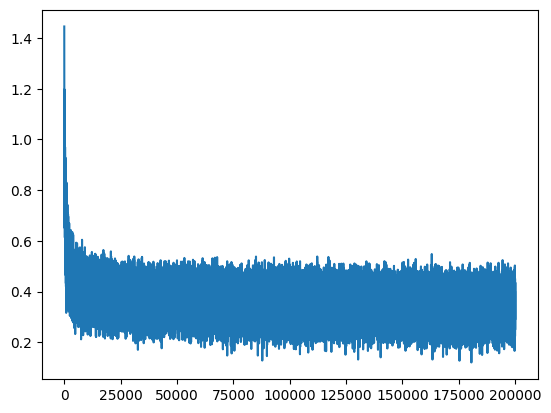

In [122]:
plt.plot(lossi)

## Obtain loss on DS splits

In [135]:
@torch.no_grad()  # This decorator disables gradient trackings
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  xemb = C[x]
  h = torch.tanh(xemb.view(-1, block_size * n_embd) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)

  return loss.item()

print(f'train loss = {split_loss("train")}, dev loss = {split_loss("dev")}')

train loss = 2.1910688877105713, dev loss = 2.2519688606262207


## Sample the model

In [177]:
for _ in range(20):
  context = [0] * block_size
  out = []

  while True:
    _tmp = torch.tensor([context])
    xemb = C[_tmp]

    h = torch.tanh(xemb.view(xemb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    iy = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)

    if iy == 0:
      break
    else:
      out.append(iy.item())
      context = context[1:] + [iy]

  print(''.join(itos[i] for i in out))




kilero
gracin
aury
orie
orue
xally
keigh
koes
ker
augison
wen
soma
logri
samari
faima
den
jaqub
kairrithmere
wester
kaylonces
